In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import osmnx as ox
import math
import pandas as pd
import random
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
 
from funciones import *
from solvers_listos import generar_ruta, graficar_rutas 
# from instancia import ubis, cap_tpte, info_locales
# from instancia import G, color_nodos, color_arcos, ancho_edges
from ruteo_alns import ruteo_ALNS

random.seed(1)
np.random.seed(1)

{0: 0, 1: 91, 2: 27, 3: 11, 4: 63, 5: 69, 6: 67, 7: 91, 8: 46, 9: 73, 10: 66}


# Instancia

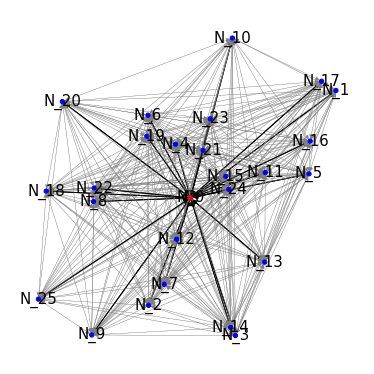

{'Inv': 3023, 'Up': 1000000, 'Low': 0, 'Prod': 1250, 'h': 0.3, 'coord_x': 255, 'coord_y': 230, 'pos': (255, 230)}
{'Inv': 17, 'Up': 34, 'Low': 0, 'Prod': 17, 'h': 0.2, 'coord_x': 498, 'coord_y': 404, 'pos': (498, 404)}
{'Inv': 106, 'Up': 159, 'Low': 0, 'Prod': 53, 'h': 0.19, 'coord_x': 185, 'coord_y': 56, 'pos': (185, 56)}
{'Inv': 41, 'Up': 82, 'Low': 0, 'Prod': 41, 'h': 0.24, 'coord_x': 330, 'coord_y': 7, 'pos': (330, 7)}
{'Inv': 13, 'Up': 26, 'Low': 0, 'Prod': 13, 'h': 0.22, 'coord_x': 230, 'coord_y': 317, 'pos': (230, 317)}
{'Inv': 21, 'Up': 42, 'Low': 0, 'Prod': 21, 'h': 0.4, 'coord_x': 453, 'coord_y': 269, 'pos': (453, 269)}
{'Inv': 29, 'Up': 58, 'Low': 0, 'Prod': 29, 'h': 0.45, 'coord_x': 184, 'coord_y': 364, 'pos': (184, 364)}
{'Inv': 186, 'Up': 279, 'Low': 0, 'Prod': 93, 'h': 0.16, 'coord_x': 211, 'coord_y': 90, 'pos': (211, 90)}
{'Inv': 26, 'Up': 52, 'Low': 0, 'Prod': 26, 'h': 0.17, 'coord_x': 93, 'coord_y': 224, 'pos': (93, 224)}
{'Inv': 66, 'Up': 132, 'Low': 0, 'Prod': 66, '

In [32]:
G, ubis, cap_tpte, info_locales = crear_grafo_inicial(archivo= 'IRP1.xlsx' ,plot=True)
for nodo in G.nodes(data=True):
    si_o_no = random.randint(0,1)
    if False and nodo[0] != 'N_0':
        up = nodo[1]['Up']
        new_d = random.randint(int(up*0.25), int(up*0.75))
        G.nodes[nodo[0]]['Prod'] = new_d
        G.nodes[nodo[0]]['Inv'] = up - new_d

    print(G.nodes(data=True)[nodo[0]])

In [33]:
# def reaccion_inventario(grafo, mu, sd, alfa = 0.05):
#     """
#     Función que verifica que locales deben ser visitados en base a su inventario actual. 
#     En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
#     """
#     grafo = G.copy()
#     visitas = {nodo : False for nodo in G.nodes()}
#     for nodo in grafo.nodes(data=True):
#         id_nodo = int(nodo[0][2:])-1
#         media = mu[id_nodo]
#         desviacion = sd[id_nodo]
#         s = media + norm.ppf((1 - alfa)/2) * desviacion  #Stock de segrafouridad
#         if nodo[1]['Inv'] <= s:
#             visitas[nodo[0]] = True
    
#     return visitas

In [34]:


#ejemplo demanda historica

muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido=0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    print(demanda)
    print(dem_historico.keys())
    plt.figure(figsize=(10, 5))
    plt.plot(demanda.values(), 'o', color='black') 
    # for nodo in dem_historico.keys():
    #     if nodo != 'N_0':
    #         # plt.plot(dem_historico[nodo])
    #         plt.plot(smooth(dem_historico[nodo], 10))
    plt.xlabel('Días')
    plt.ylabel('Demanda')
    plt.xticks(np.arange(len(demanda)), demanda.keys())
    plt.title('Demanda histórica')
    plt.show()


In [35]:
muestra = False

if muestra:
    dem_historico = simular_demanda_previa(G, dist = 'n', T=1000, ruido = 0.05) 
    demanda = {nodo: dem_historico[nodo][-1] for nodo in dem_historico.keys()}
    data = {nodo: dem_historico[nodo][1:] for nodo in dem_historico.keys()}
    y = [SEDA(data[nodo], historia=False, alpha = 0.5) for nodo in data.keys()]
    medias = [np.mean(data[nodo]) for nodo in data.keys()]
    ind = np.arange(len(y))

    # y = [SEDA(dem_historico[nodo], pron=True, alpha = 0.5) for nodo in set(dem_historico)-set(['N_0'])]
    # medias = [np.mean(dem_historico[nodo]) for nodo in set(dem_historico)-set(['N_0'])]
    # ind = np.arange(len(y))
    
    # print(y)
    ancho = 0.3
    plt.figure(figsize=(10, 5))
    plt.plot(y, 'o', label='Pronóstico', color='red')
    plt.plot(medias, 'o', label='Promedio', color='blue')
    plt.plot(demanda.values(), 'o', label='Realización', color='black')
    # plt.bar(ind, y, width=ancho, label='Pronóstico', color='red')
    # plt.bar(ind + ancho, medias, width=ancho, label='Promedio', color='blue')
    plt.xticks(ind + ancho / 2, [f'N_{i}' for i in range(1,len(y)+1)])

    plt.xlabel('Local')
    plt.ylabel('Demanda')
    plt.title('Demanda: Pronóstico y realización para t+1')
    plt.legend()
    plt.show()

In [36]:


# Gprima, d, ins = realizacion_demanda(G)

# for nodo in Gprima.nodes(data=True):
#     print(nodo[0],nodo[1]['Inv'])

def proactiva_inventario(G, pronostico, mu, sd, alfa = 0.05, tolerancia = 0.5):
    """
    Función que verifica que locales deben ser visitados en base a su inventario. 
    En caso de que el inventario se encuentre bajo el umbral de tolerancia, se retorna True.
    """
    visitas = {nodo : False for nodo in G.nodes()}
    for nodo in G.nodes(data=True):
        id_nodo = int(nodo[0][2:])-1
        media = mu[id_nodo]
        desviacion = sd[id_nodo]
        s = media + norm.ppf((1 - alfa)/2)* desviacion  #Stock de seguridad
        if nodo[1]['Inv'] <= s:
            visitas[nodo[0]] = True
            
    for nodo in G.nodes(data=True):
        mean = nodo[1]['Prod'] + mu
        sd = nodo[1]['Prod'] * sigma
        l_inf, l_sup = IC_nrm(mean, sd, alfa = 0.95)
        pronostico = l_sup
        if nodo[1]['Inv'] - pronostico <= tolerancia * nodo[1]['Up']:
            visitas[nodo[0]] = True
    
    return visitas



In [37]:
dem_historico_test = simular_demanda_previa(G, dist = 'n', T=1000) 
mu_d = [np.mean(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]    
sd_d = [np.std(dem_historico_test[nodo]) for nodo in dem_historico_test.keys()]
vis = reaccion_inventario(G, mu_d, sd_d)
np.sum(mu_d)

3023, s0 = 72.60975350897797, False
17, s1 = 16.9655405917258, False
106, s2 = 52.70988267984041, False
41, s3 = 40.87238779933463, False
13, s4 = 12.918884377376331, False
21, s5 = 20.92334932861015, False
29, s6 = 28.861232896310188, False
186, s7 = 92.59118847484935, False
26, s8 = 25.97412437801246, False
66, s9 = 65.91556834923132, False
99, s10 = 98.85857277141952, False
71, s11 = 70.80794664680847, False
90, s12 = 44.82647610323168, False
110, s13 = 54.976850582276484, False
124, s14 = 61.71499759422305, False
29, s15 = 28.84362839592506, False
134, s16 = 66.79389690187337, False
98, s17 = 97.61285401401288, False
20, s18 = 19.9406828783142, False
122, s19 = 60.89424805768177, False
16, s20 = 15.974704433655134, False
45, s21 = 44.84409234487816, False
112, s22 = 55.8357126175703, False
63, s23 = 62.83950623949225, False
62, s24 = 30.961560620454122, False
73, s25 = 72.60975350897797, False


1250.0130999318094

In [38]:
def simular_ejecucion_R(grafo_inicial = G, T=1):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [[G0.nodes(data=True)[i]['Inv'] for i in ubicaciones]] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : [] for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        mu_demanda = [np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()]    
        sd_demanda = [np.std(dem_historico[nodo]) for nodo in dem_historico.keys()]
        # pronostico = [pronostico_SEDA(dem_historico[nodo], T = 10, pron = True, alpha=0.1, beta=0.1, theta=0.5) for nodo in dem_historico.keys()]

        # Estrategia Reactiva (R)  
        # print([G0.nodes(data=True)[i]['Inv'] for i in ubicaciones])
        visitas_reaccion = reaccion_inventario(G0, mu_demanda, sd_demanda)
        print("Visitas reacción: ", visitas_reaccion)
        if sum(visitas_reaccion.values()) == 0:
            print("No hay locales que visitar")
            rutas[t] = []

        else:    
            ruta_R, largo_ruta_R = generar_ruta(G0, matriz_dst, visitas_reaccion) #devuelve la ruta a realizar
            rutas[t] = ruta_R
            print(f"Ruta {t}: ", ruta_R )
            G0, stock = ejecutar_ruta(G0, ruta_R, matriz_dst)
            
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        perdido += insatisfecho

        inventarios.append([G0.nodes(data=True)[i]['Inv'] for i in ubicaciones])
        
        # costo = sum([h[i]*inventarios[i] for i in range(len(inventarios))])
        
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')
    
    return rutas, dem_historico
        
        
mis_rutas, dem_historico = simular_ejecucion_R(grafo_inicial = G, T = 365)
        

Inventario inicial: 
N_0 3023
N_1 17
N_2 106
N_3 41
N_4 13
N_5 21
N_6 29
N_7 186
N_8 26
N_9 66
N_10 99
N_11 71
N_12 90
N_13 110
N_14 124
N_15 29
N_16 134
N_17 98
N_18 20
N_19 122
N_20 16
N_21 45
N_22 112
N_23 63
N_24 62
N_25 73


3023, s0 = 72.89355427737131, False
17, s1 = 16.941320435408784, False
106, s2 = 52.9134802075952, False
41, s3 = 40.89092159465985, False
13, s4 = 12.954420193177297, False
21, s5 = 21.017053417194823, True
29, s6 = 28.873143424792197, False
186, s7 = 92.80680695920728, False
26, s8 = 25.836216426656872, False
66, s9 = 66.0653929593549, True
99, s10 = 98.85925103039075, False
71, s11 = 70.68598004455201, False
90, s12 = 44.776562399453795, False
110, s13 = 54.89104269150121, False
124, s14 = 61.82616914940303, False
29, s15 = 28.80051110342764, False
134, s16 = 66.86297869108444, False
98, s17 = 97.73532415413406, False
20, s18 = 19.96968144055934, False
122, s19 = 60.66605280345521, False
16, s20 = 15.93354398228924, False
45, s21 = 44.78545270288677, False


In [39]:
def simular_ejecucion_P_LS(grafo_inicial = G, T=1, F=1, cap = cap_tpte):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

# simular_ejecucion_P(grafo_inicial = G, T = 5, cap = 871)

In [5]:
from ruteo_alns import ruteo_ALNS
cap_tpte = 871
def simular_ejecucion_P_ALNS(grafo_inicial, T=1, F=1, cap = cap_tpte):
    # Inicializar variables     
    # ---------------------
    G0 = grafo_inicial.copy()
    matriz_dst = calcular_matriz_dist(G0)
    ubicaciones = list(G0.nodes()) # Lista de ubicaciones
    inventarios = [G0.nodes(data=True)[i]['Inv'] for i in ubicaciones] # Lista de inventarios
    h = [G0.nodes(data=True)[i]['h'] for i in ubicaciones] # Lista de costos de inventario
    rutas = {t : None for t in range(T)} # Lista de rutas
    dem_historico = simular_demanda_previa(G0, dist = 'n', T=1000) 
    perdido = 0
    print("Inventario inicial: ")
    for nodo in G0.nodes(data=True):
            print(nodo[0],nodo[1]['Inv'])
    print("\n")

    for t in range(T):
        pronostico = {int(nodo[2:]):
                pronostico_SEDA(dem_historico[nodo], T = 1, pron = True, alpha=0.2, beta=0.1, theta=0.5)[0]
                for nodo in dem_historico.keys()}
        # print(pronostico)
         
        ruta_P = ruteo_ALNS(G0, pronostico, cap = cap, F = F, ruta = True, MRT = 10) + ['N_0']
        rutas[t] = ruta_P
        print(f"Ruta {t}: ", ruta_P )
        # visitas_proactiva = proactiva_inventario(G0, tolerancia = 0.2, dist = 'n', mu = 0, sigma = 0.1, M = 1000)

        G0, stock = ejecutar_ruta(G0, ruta_P, matriz_dst)
        G0, demanda, insatisfecho = realizacion_demanda(G0)
        
        perdido += insatisfecho

        #Actualizo demandas
        for nodo in ubicaciones:
            if nodo != 'N_0':
                dem_historico[nodo].append(demanda[nodo])


    print('\n')
    print("Inventario final: ")
    for nodo in G0.nodes(data=True):
        print(nodo[0],nodo[1]['Inv'])
    print(f'Demanda perdida total: {perdido} | Demanda perdida promedio: {perdido/T}')        

    graficar_rutas(rutas, G0)

# simular_ejecucion_P_ALNS(grafo_inicial = G, T = 5, cap = 871)

In [41]:
mis_rutas
mis_rutas_t = {t : str(mis_rutas[t]) for t in mis_rutas.keys()}
df_rutas = pd.DataFrame.from_dict(mis_rutas_t, orient='index', columns=['Ruta'])
df_rutas.value_counts()

Ruta                                                                                                                                                            
['N_0', 'N_11', 'N_17', 'N_10', 'N_23', 'N_20', 'N_18', 'N_22', 'N_8', 'N_12', 'N_7', 'N_2', 'N_9', 'N_3', 'N_0']                                                   1
['N_0', 'N_24', 'N_15', 'N_11', 'N_5', 'N_1', 'N_17', 'N_10', 'N_6', 'N_4', 'N_8', 'N_18', 'N_25', 'N_9', 'N_2', 'N_3', 'N_0']                                      1
['N_0', 'N_24', 'N_15', 'N_11', 'N_16', 'N_5', 'N_13', 'N_14', 'N_2', 'N_9', 'N_25', 'N_12', 'N_8', 'N_18', 'N_20', 'N_6', 'N_4', 'N_21', 'N_23', 'N_10', 'N_0']    1
['N_0', 'N_24', 'N_15', 'N_11', 'N_16', 'N_17', 'N_21', 'N_4', 'N_19', 'N_6', 'N_20', 'N_18', 'N_22', 'N_8', 'N_12', 'N_3', 'N_0']                                  1
['N_0', 'N_24', 'N_15', 'N_11', 'N_16', 'N_1', 'N_17', 'N_10', 'N_23', 'N_4', 'N_20', 'N_22', 'N_18', 'N_25', 'N_9', 'N_2', 'N_0']                                  1
         

## Procesamiento de Resultados

In [42]:
N = len(G.nodes())-1
def generar_df(rutas, N):

    rutas_bool = dict()
    for ruta, nodos in rutas.items():
        bools = dict()
        for i in range(1, N+1):
            if f'N_{i}' in nodos:
                bools[f'N_{i}'] = 1
            else:
                bools[f'N_{i}'] = 0
        rutas_bool[ruta] = bools
    
    df = pd.DataFrame.from_dict(rutas_bool, orient='index')
    
    df.rename(columns={'index': 'Ruta', 0: 'Nodo'}, inplace=True)
    df.rename_axis('Ruta', inplace=True)
    return df

df = generar_df(mis_rutas, N)
df['sum'] = df.sum(axis=1)


In [43]:
df_nodos = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
df_nodos = df_nodos.iloc[1:]
df_nodos['frec'] = (df.describe()).T['mean']
dem_historico_media = {nodo: np.mean(dem_historico[nodo]) for nodo in dem_historico.keys()}
df_nodos['dem_mean'] = dem_historico_media.values()
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean
N_1,17,34,0,17,0.20,498,404,"(498, 404)",0.649315,17.001061
N_2,106,159,0,53,0.19,185,56,"(185, 56)",0.408219,53.084440
N_3,41,82,0,41,0.24,330,7,"(330, 7)",0.679452,41.004139
N_4,13,26,0,13,0.22,230,317,"(230, 317)",0.649315,12.997100
N_5,21,42,0,21,0.40,453,269,"(453, 269)",0.676712,21.068232
N_6,29,58,0,29,0.45,184,364,"(184, 364)",0.671233,28.976678
N_7,186,279,0,93,0.16,211,90,"(211, 90)",0.400000,92.978307
N_8,26,52,0,26,0.17,93,224,"(93, 224)",0.635616,25.894666
N_9,66,132,0,66,0.26,90,8,"(90, 8)",0.671233,66.175228
N_10,99,198,0,99,0.24,325,489,"(325, 489)",0.654795,99.106007


In [44]:
indices_mayores = df_nodos[df_nodos['frec'] > 0.75].index
indices_medios = df_nodos[(df_nodos['frec'] > 0.45) & (df_nodos['frec'] <= 0.75)].index
indices_menores = df_nodos[df_nodos['frec'] <= 0.45].index

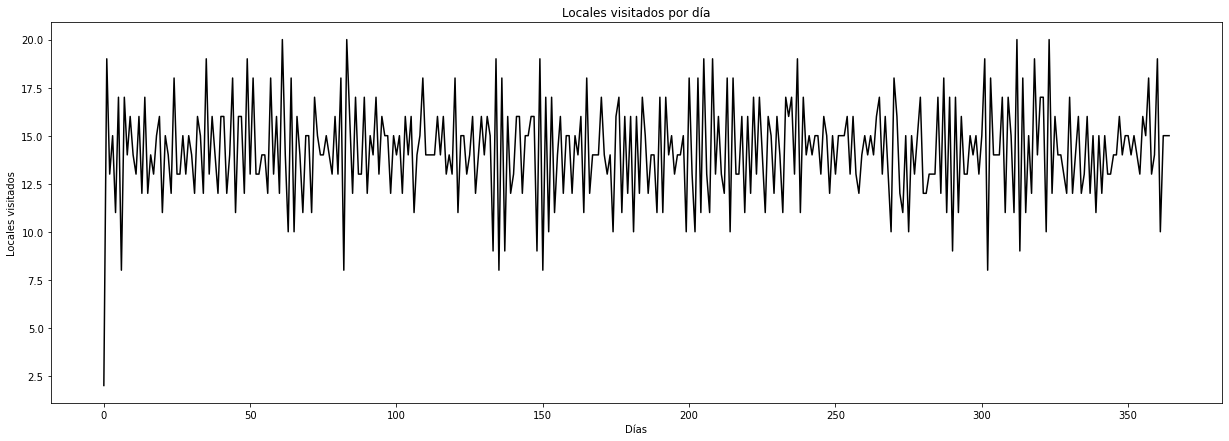

In [45]:
# graficaremos una serie de tiempo para el total de locales en cada día
# para esto, debemos sumar la cantidad de locales visitados en cada día, ya lo hicimos en la última columna

plt.figure(figsize=(21, 7))
plt.plot(df['sum'], '-', color='black')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.show()

In [ ]:
"""
# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico
# lo haremos solo con los primeros 150 días
plt.figure(figsize=(30, 7))
for i in range(1, N+1):
    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')
plt.xlabel('Días')
plt.ylabel('Locales visitados')
plt.title('Locales visitados por día')
plt.legend()
plt.show()
"""

"\n# replicamos algo así pero ahora para cada local en vez de la suma, lo haremos sobre el mismo gráfico\n# lo haremos solo con los primeros 150 días\nplt.figure(figsize=(30, 7))\nfor i in range(1, N+1):\n    plt.plot(df[f'N_{i}'][:150], '-', label=f'N_{i}')\nplt.xlabel('Días')\nplt.ylabel('Locales visitados')\nplt.title('Locales visitados por día')\nplt.legend()\nplt.show()\n"

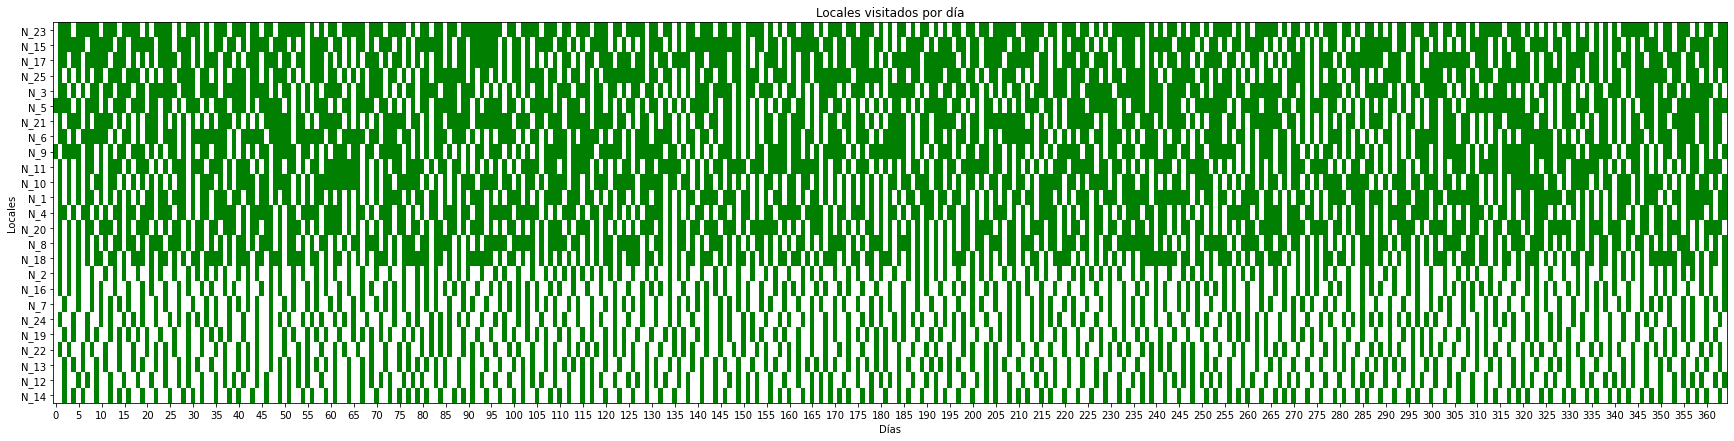

In [46]:

from matplotlib.colors import ListedColormap


# Define colormap

cmap = ListedColormap(['w', 'g'], N=2)

# Plot matrix

fig, ax = plt.subplots(figsize=(30, 7))
if 'sum' in df.columns:
    df.drop('sum', axis=1, inplace=True)
df_plot = df.T
df_plot['suma'] = df_plot.sum(axis=1)   
df_plot.sort_values(by='suma', inplace=True, ascending=False)
df_plot.drop('suma', axis=1, inplace=True)
ax.imshow(df_plot, cmap=cmap, vmin=0, vmax=1, aspect='auto')
ax.set_title('Locales visitados por día')
ax.set_xlabel('Días')
ax.set_ylabel('Locales')
ax.set_yticks(np.arange(N))
ax.set_yticklabels(list(df_plot.index))
ax.set_xticks(np.arange(0, len(df), 5))

# modificamos el tamaño de la figura

plt.show()

In [47]:
cantidad_06 = len(df_nodos[df_nodos['frec'] >= 0.5])
cantidad_04 = len(df_nodos[df_nodos['frec'] < 0.5])

print (f'Locales visitados más de 50% de los días: {cantidad_06}, que corresponde a un {cantidad_06/N*100}%')
print (f'Locales visitados menos de 50% de los días: {cantidad_04}, que corresponde a un {cantidad_04/N*100}%')

Locales visitados más de 50% de los días: 16, que corresponde a un 64.0%
Locales visitados menos de 50% de los días: 9, que corresponde a un 36.0%


In [48]:
def dispersion_intervalos(df):
    '''
    Función que calcula la cantidad promedio de días entre visitas a cada local.
    También entrega la desviación estándar de los intervalos.
    '''
    df = df.copy()
    if 'sum' in df.columns:
        df.drop('sum', axis=1, inplace=True)
    datos = {nodo: {'mean': None, 'std': None} for nodo in df.columns}
    for nodo in df.columns:
        largos = []
        ultima_visita = 0
        for dia in range(len(df)):
            if df[nodo][dia] == 1:
                if dia - ultima_visita > 3:
                    #print(f'El local {nodo} no fue visitado por {dia - ultima_visita} días')
                    pass
                largos.append(dia - ultima_visita)
                ultima_visita = dia
        datos[nodo]['mean'] = np.mean(largos)
        datos[nodo]['std'] = np.std(largos)
    datos_df = pd.DataFrame.from_dict(datos, orient='index')
    return datos_df

datos = dispersion_intervalos(df)
        

df_nodos['mean'] = datos['mean']
df_nodos['std'] = datos['std']
df_nodos['porcentaje demanda'] = df_nodos['dem_mean'] / df_nodos['Up']
df_nodos['porcentaje dem. inicial'] = df_nodos['Prod'] / df_nodos['Up']
df_nodos_corr = df_nodos[['Inv','Up','Low','Prod','h','frec','mean','std','dem_mean','porcentaje demanda','porcentaje dem. inicial']]


In [49]:
df_nodos

,Inv,Up,Low,Prod,h,coord_x,coord_y,pos,frec,dem_mean,mean,std,porcentaje demanda,porcentaje dem. inicial
N_1,17,34,0,17,0.20,498,404,"(498, 404)",0.649315,17.001061,1.535865,0.498712,0.500031,0.500000
N_2,106,159,0,53,0.19,185,56,"(185, 56)",0.408219,53.084440,2.442953,0.510067,0.333864,0.333333
N_3,41,82,0,41,0.24,330,7,"(330, 7)",0.679452,41.004139,1.463710,0.498681,0.500050,0.500000
N_4,13,26,0,13,0.22,230,317,"(230, 317)",0.649315,12.997100,1.535865,0.498712,0.499888,0.500000
N_5,21,42,0,21,0.40,453,269,"(453, 269)",0.676712,21.068232,1.473684,0.507351,0.501625,0.500000
N_6,29,58,0,29,0.45,184,364,"(184, 364)",0.671233,28.976678,1.481633,0.499663,0.499598,0.500000
N_7,186,279,0,93,0.16,211,90,"(211, 90)",0.400000,92.978307,2.493151,0.499953,0.333256,0.333333
N_8,26,52,0,26,0.17,93,224,"(93, 224)",0.635616,25.894666,1.568966,0.495221,0.497974,0.500000
N_9,66,132,0,66,0.26,90,8,"(90, 8)",0.671233,66.175228,1.485714,0.507897,0.501327,0.500000
N_10,99,198,0,99,0.24,325,489,"(325, 489)",0.654795,99.106007,1.523013,0.499470,0.500535,0.500000


In [50]:
df_nodos_corr.corr()

,Inv,Up,Low,Prod,h,frec,mean,std,dem_mean,porcentaje demanda,porcentaje dem. inicial
Inv,1.000000,0.972775,NaN,0.789702,-0.103887,-0.723721,0.736818,0.287086,0.788763,-0.751959,-0.755120
Up,0.972775,1.000000,NaN,0.910380,-0.141522,-0.561496,0.577403,0.227993,0.909745,-0.596414,-0.600482
Low,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Prod,0.789702,0.910380,NaN,1.000000,-0.189154,-0.194244,0.212969,0.090972,0.999994,-0.236263,-0.241387
h,-0.103887,-0.141522,NaN,-0.189154,1.000000,-0.087601,0.077159,0.494741,-0.189478,-0.088076,-0.087193
frec,-0.723721,-0.561496,NaN,-0.194244,-0.087601,1.000000,-0.998728,-0.427537,-0.192727,0.993025,0.992296
mean,0.736818,0.577403,NaN,0.212969,0.077159,-0.998728,1.000000,0.428704,0.211485,-0.996731,-0.996268
std,0.287086,0.227993,NaN,0.090972,0.494741,-0.427537,0.428704,1.000000,0.090992,-0.464547,-0.467083
dem_mean,0.788763,0.909745,NaN,0.999994,-0.189478,-0.192727,0.211485,0.090992,1.000000,-0.234873,-0.240023
porcentaje demanda,-0.751959,-0.596414,NaN,-0.236263,-0.088076,0.993025,-0.996731,-0.464547,-0.234873,1.000000,0.999943
